# PixelCNN

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

In [2]:
# parameters from the paper
batch_size = 16
num_layers = 7
num_channels = 32

# other parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001
num_epochs = 10

The architecture is designed for MNIST only and for static inputs.

In [3]:
# architecture
# 1. 7 x 7 with conv mask A
# 2. stack 3 x 3 with conv mask B
# 3. ReLU + 1x1 conv layer with mask B (2 layers)
# 4. 256 Ways softmax

In [4]:
# Type A or B masked Conv2d 
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask='A'): 
        super().__init__()
        # calculate the padding automatically 
        # so that input width+height dims = output dims
        padding = int((kernel_size - 1) / 2)
        
        self.conv = nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             padding=padding)
        
        # calculate masks A or B as in the original paper
        mask_idxs = torch.arange(0, kernel_size**2).view(kernel_size, kernel_size)
        if mask == 'A':
            mask = (mask_idxs < padding * kernel_size + padding).float().to(device)
        elif mask == 'B':
            mask = (mask_idxs <= padding * kernel_size + padding).float().to(device)
        self.register_buffer('mask', mask)
            
    def forward(self, x):
        # apply mask, see below link for more info
        # https://discuss.pytorch.org/t/applying-custom-mask-on-kernel-for-cnn/87099
        
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
        return self.conv(x)

In [5]:
test2dLayer = MaskedConv2d(in_channels=1, out_channels=num_channels, kernel_size=7).to(device)
testdata = torch.randn(1, 1, 28, 28, device=device)
test2dLayer(testdata).shape

torch.Size([1, 32, 28, 28])

In [6]:
class PixelCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                MaskedConv2d(in_channels=1, out_channels=num_channels, kernel_size=7, mask='A'), 
                nn.ReLU(),
                MaskedConv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, mask='B'), 
                nn.ReLU(),
                MaskedConv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, mask='B'), 
                nn.ReLU(),
                nn.Conv2d(num_channels, num_channels*2, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(num_channels*2, 1, kernel_size=1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [7]:
test_images = torch.randn(batch_size, 1, 28, 28, device=device)
model = PixelCNN().to(device)
model(test_images).shape

torch.Size([16, 1, 28, 28])

In [8]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=True, 
                                           transform=T.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=False, 
                                           transform=T.ToTensor(), 
                                           download=False)

In [9]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

In [10]:
model = PixelCNN().to(device)
# mse would most likely also work
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
def train():
    for epoch in range(1, num_epochs+1):
        train_loss = []
        for features, _ in train_dataloader:
            features = features.to(device)
            logits = model(features)
            loss = criterion(logits, features)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.cpu().item())
        
        print(f'Epoch: {epoch}/{num_epochs}, Loss: {sum(train_loss)/len(train_loss)}')

In [12]:
train()

Epoch: 1/10, Loss: 0.2159466097275416
Epoch: 2/10, Loss: 0.15636947104732196
Epoch: 3/10, Loss: 0.1425755455116431
Epoch: 4/10, Loss: 0.13435178312460583
Epoch: 5/10, Loss: 0.13021393516461055
Epoch: 6/10, Loss: 0.12761547727584838
Epoch: 7/10, Loss: 0.12626338642636936
Epoch: 8/10, Loss: 0.12538899948398272
Epoch: 9/10, Loss: 0.12458948510885239
Epoch: 10/10, Loss: 0.12399486711819967


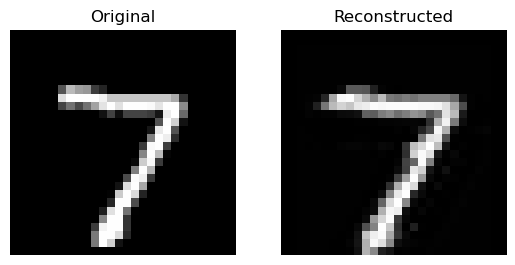

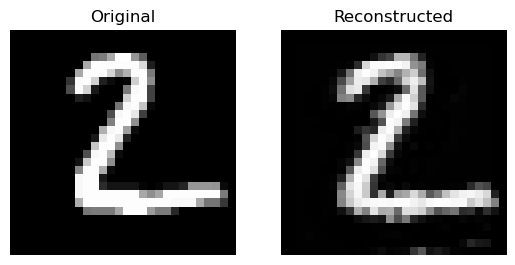

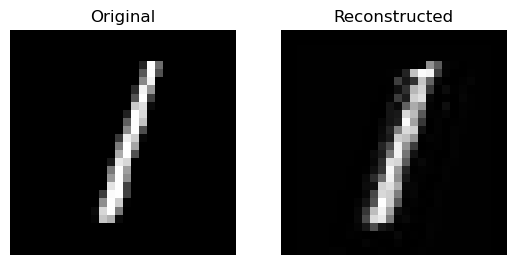

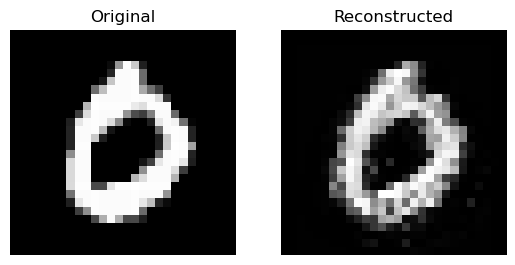

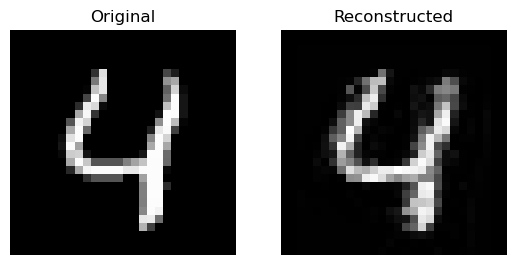

In [13]:
# test the reconstruction by comparing original images with the reconstructed images
with torch.inference_mode():
    for idx in range(5):
        image, _ = test_dataset[idx]
        image = image.unsqueeze(0)
        generated_image = model(image.to(device))
        generated_image = torch.sigmoid(generated_image)
        generated_image = generated_image.squeeze()

        plt.subplot(1, 2, 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(generated_image.cpu(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
        plt.show()

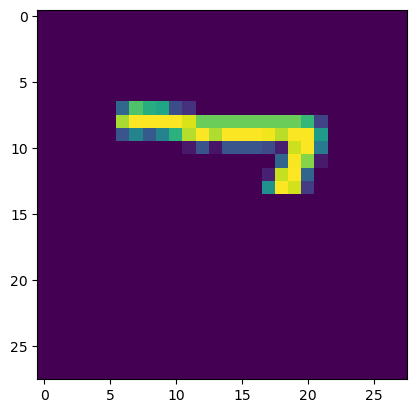

In [14]:
image, _ = test_dataset[0]
image = image.squeeze()
for row_idx, row in enumerate(image):
    for col_idx, _ in enumerate(image):
        if row_idx >= 14:
            image[row_idx][col_idx] = 0
plt.imshow(image.squeeze())

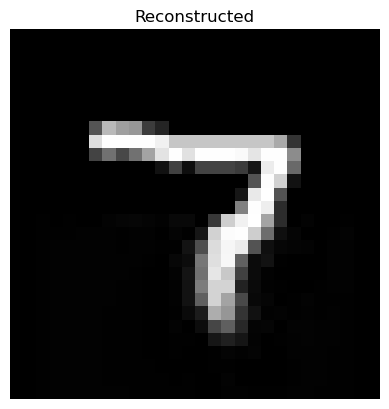

In [18]:
image, _ = test_dataset[0]
image = image.squeeze()
for row_idx, row in enumerate(image):
    for col_idx, _ in enumerate(image):
        if row_idx >= 14:
            image[row_idx][col_idx] = 0

image = image.unsqueeze(0).unsqueeze(0).to(device) 
with torch.inference_mode():
    for row_idx in range(28):
        for col_idx in range(28):
            generated_image = model(image)
            generated_image = torch.sigmoid(generated_image)
            generated_image = generated_image.squeeze()
            if row_idx >=14:
                image[0][0][row_idx][col_idx] = generated_image[row_idx][col_idx]
            
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")
plt.show()
